In [1]:
#define the colors from colorbrewer2
orange1 = '#feedde'
orange2 = '#fdbe85'
orange3 = '#fd8d3c'
orange4 = '#e6550d'
orange5 = '#a63603'
blue1 = '#eff3ff'
blue2 = '#bdd7e7'
blue3 = '#6baed6'     
blue4 = '#3182bd'     # passenger colour
blue5 = '#08519c'
green1 = '#edf8e9'
green2 = '#bae4b3'
green3 = '#74c476'   # dev colour
green4 = '#31a354'
green5 = '#006d2c'
grey1 = '#f7f7f7'
grey2 = '#cccccc'
grey3 = '#969696'
grey4 = '#636363'     # neutral drift colour
grey5 = '#252525'
purple1 = '#f2f0f7'
purple2 = '#cbc9e2'
purple3 = '#9e9ac8'
purple4 = '#756bb1'
purple5 = '#54278f'
red1 = '#fee5d9'
red2 = '#fcae91'
red3 = '#fb6a4a'
red4 = '#de2d26'
red5 = '#a50f15'

In [2]:
# Lists of colors for plots
c0 = (0.76, 0.76, 0.76)
c1 = (1.00, 0.18, 0.33);
c2 = (1.00, 0.23, 0.19);
c3 = (1.00, 0.58, 0.00);
c4 = (1.00, 0.80, 0.00);
c5 = (0.30, 0.85, 0.39);
c6 = (0.35, 0.78, 0.98);
c7 = (0.20, 0.67, 0.86);
c8 = (0.00, 0.48, 1.00);
c9 = (0.35, 0.34, 0.84);
c10 = (0.00, 0.31, 0.57);
c11 = (0.12, 0.29, 0.69);
c12 = (0.17, 0.17, 0.42);
c13 = (1.00, 1.00, 1.00);
c14 = (0.77, 0.04, 0.00);

In [3]:
# imported packages
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import cm
import scipy.special
import scipy.integrate as it
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.stats import kde
import copy
import glob, os
import re
from sklearn import datasets, linear_model
import pandas as pd
from decimal import *
from operator import itemgetter    
from collections import OrderedDict
import timeit
import csv
from scipy.integrate import simps
import cmath
import mpmath as mp

In [4]:
Bolton_panel_size = 1139322  # bp

non_syn_mu_per_bp = 1.3617021276595745e-09
mu_per_bp = 1.9007092198581563e-09
Bolton_468panel_mu = mu_per_bp*Bolton_panel_size
Bolton_468panel_non_syn_mu = non_syn_mu_per_bp*Bolton_panel_size

print('Bolton_468panel_mu', Bolton_468panel_mu)
print('Bolton_468panel_non_syn_mu', Bolton_468panel_non_syn_mu)



Bolton_468panel_mu 0.0021655198297872344
Bolton_468panel_non_syn_mu 0.0015514171914893617


### Define DFE in healthy blood

In [5]:
# expo power + delta + p free
p_inferred = 2.94551663
q_inferred = 0.08456544
alpha = 0.02270383
s_max_inferred = float('inf')


Bolton_468panel_functional_non_syn_mu = Bolton_468panel_non_syn_mu*alpha
print('Bolton_468panel_functional_non_syn_mu', Bolton_468panel_functional_non_syn_mu)

Bolton_468panel_functional_non_syn_mu 3.522311217465192e-05


# Define the passenger prediction

In [9]:
import scipy.special as sc

N_tau=10**5

# # log concave
# weight_s= lambda s: np.exp(-((abs(s))/d_inferred)**b_inferred)
# normalization=integrate.quad(weight_s, 0.0, s_max_inferred)[0]

# # log convex
weight_s= lambda s: np.exp(-((abs(s))/q_inferred)**p_inferred)
normalization=integrate.quad(weight_s, 0.0, float("inf"))[0]


def hitchhikers_exponential_feeding_with_cutoff(l, N_tau, t, u_driver, s):
    
    N = N_tau
    
    expected_density=np.exp(l)*(2*N/(1-2*np.exp(l))**2)*N_tau*u_driver/s**2/(2*N*np.exp(l)/(1-2*np.exp(l)))**2*( \
                                                                                      np.exp(-(2*N*np.exp(l)/(1-2*np.exp(l)))*s*np.exp(-s*t))*np.exp(s*t)        -\
                                         np.exp(-(2*N*np.exp(l)/(1-2*np.exp(l)))*s)*(np.exp(s*t)+ (2*N*np.exp(l)/(1-2*np.exp(l)))*s*(np.exp(s*t)-1)  ))

    return expected_density


def minor_contribution_hitchhikers_alternative_theory_with_cutoff(l, N_tau, t, u_driver, s):
    N=N_tau
    tau=1
    expected_density=np.exp(l)*N*tau*u_driver/(np.exp(l)*s*(1-2*np.exp(l)))*(-s*t*np.exp(-(2*N*np.exp(l)/(1-2*np.exp(l)))*s*tau)+sc.expi(-(2*N*np.exp(l)/(1-2*np.exp(l)))*s*tau) -\
                                                   sc.expi(-(2*N*np.exp(l)/(1-2*np.exp(l)))*s*tau*np.exp(-s*t)))
    

    return expected_density


def expected_density_hitchhiker_mutants_s_single(t, l, s1, b, d, mu_ben, N_tau):
    
    u_driver_at_s1 = mu_ben*np.exp(-((abs(s1))/d)**b)/normalization

#     psi = np.log(N_tau*s1+1)/s1
    relative_fitness=0.05
    psi = np.log((s1/relative_fitness-1)*N_tau*s1+1)/s1
    
    if t>psi:
        density = hitchhikers_exponential_feeding_with_cutoff(l, N_tau, psi, u_driver_at_s1, s1)+\
        + minor_contribution_hitchhikers_alternative_theory_with_cutoff(l, N_tau, psi, u_driver_at_s1, s1)

    else:
        density = hitchhikers_exponential_feeding_with_cutoff(l, N_tau, t, u_driver_at_s1, s1)+\
        + minor_contribution_hitchhikers_alternative_theory_with_cutoff(l, N_tau, t, u_driver_at_s1, s1)
    
    return density

def expected_number_hitchhiker_mutants(t, l, b, d, mu_ben, s_lower, s_upper, N_tau):
    
    result = integrate.quad(lambda s_var: expected_density_hitchhiker_mutants_s_single(t,  l, s_var,\
                                                                        b, d, mu_ben, N_tau), s_lower, s_upper)[0]

    return result

def logProbtheory_actual_ages_hitch(l, params, N_tau, s_lower, s_upper, list_of_control_ages): #= predicted density (i.e. normalised by 2 x mu)
    "Natural log of the probability of observing a variant within a specific binwidth if able to sequence perfectly"
    total_density=0.0
    
    b = params[0] 
    d = params[1]
    mu_ben= params[2]
    
    for i in range(len(list_of_control_ages)):
        age = list_of_control_ages[i]
        total_density= total_density + expected_number_hitchhiker_mutants(age, l, b, d, mu_ben, s_lower, s_upper, N_tau)/len(list_of_control_ages)

    
    return np.log(total_density)



# Plot the passenger prediction 

In [16]:
s_tolerance=3.5/100
print('The DFE has a lower cutt off at s=', s_tolerance)

list_of_control_ages = [20]

color_6p = '#1a9641'
color_9p = '#a6d96a'
color_12p = '#fdae61' # orange
color_15p = '#d7191c' # red
color_beyond15p = '#756bb1' # purple

The DFE has a lower cutt off at s= 0.035


C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in log
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log


Time:  2.5580656000000204


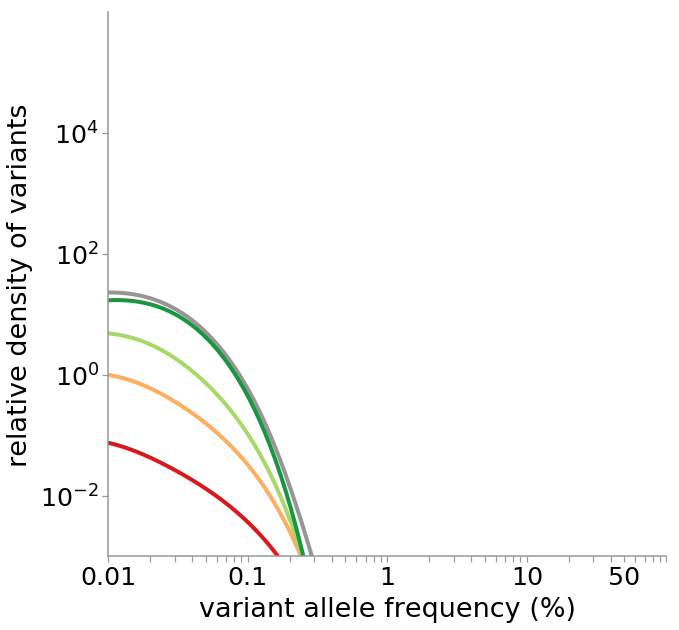

In [17]:
# # if log convex
import timeit

start = timeit.default_timer()

s_max_inferred = 1 # same result as 10

plt.close('all')
scale = 1.2
f, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(10, 10))
font = {'weight' : 'normal','size'   : 25}

x_passenger=np.linspace(np.log(10**-4), np.log(0.4999999), 100)


y_passenger_total = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_functional_non_syn_mu], N_tau, s_tolerance, s_max_inferred, list_of_control_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_total, c = grey3, lw = 4, label= 'total from 3.5 %')

y_passenger_beyond_15p = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_functional_non_syn_mu], N_tau, 0.2, 0.25, list_of_control_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_beyond_15p, c = color_beyond15p, lw = 4, label= 'beyond 20 %')

y_passenger_beyond_12p = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_functional_non_syn_mu], N_tau, 0.15, 0.2, list_of_control_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_beyond_12p, c = color_15p, lw = 4, label= '15 - 20 %')

y_passenger_12p = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_functional_non_syn_mu], N_tau, 0.12, 0.15, list_of_control_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_12p, c = color_12p, lw = 4, label= '12 - 15 %')

y_passenger_9p = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_functional_non_syn_mu], N_tau, 0.09, 0.12, list_of_control_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_9p, c = color_9p, lw = 4, label= '9 - 12 %')

y_passenger_6p = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_functional_non_syn_mu], N_tau, 0.035, 0.09, list_of_control_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_6p, c = color_6p, lw = 4, label= '3.5 - 9 %')

# Set axis limits
ax1.set_ylim(np.log(10**-3), np.log(1000000))
ax1.set_xlim(np.log(10**-4),np.log(0.5))

# # Axis labels
axisfont=14*1.2
axislabelfont=15*1.2

ax1.set_xlabel('variant allele frequency (%)', fontsize = axislabelfont*1.5, labelpad = 6*1.2, fontweight = 'medium')
ax1.set_ylabel('relative density of variants', fontsize = axislabelfont*1.5, labelpad = 6*1.2, fontweight = 'medium')

x_major_ticks = [np.log(0.0001),np.log(0.0002),np.log(0.0003),np.log(0.0004),np.log(0.0005),np.log(0.0006),np.log(0.0007),np.log(0.0008), np.log(0.0009),\
                 np.log(0.001), np.log(0.002),np.log(0.003),np.log(0.004),np.log(0.005),np.log(0.006),np.log(0.007),np.log(0.008),np.log(0.009), \
                 np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                 np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]
x_major_tick_labels = ["0.01","","","","","","","","",\
                       "0.1","","","","","","","","",\
                       "1","","","","","","","","",\
                       "10","","","","50","","","","",""]
ax1.set_xticks(x_major_ticks)
ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont*1.5)
ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)

y_major_ticks = [\
#                  np.log(10**-14), np.log(10**-12), np.log(10**-10), np.log(10**-8), np.log(10**-6),\
#                  np.log(10**-4), \
                 np.log(10**-2),\
                 np.log(1), np.log(10**2), np.log(10**4)]
y_major_tick_labels = [\
#                        "$10^{-14}$","$10^{-12}$","$10^{-10}$","$10^{-8}$","$10^{-6}$",\
#                        "$10^{-4}$",\
                       "$10^{-2}$",\
                      "$10^{0}$","$10^{2}$","$10^{4}$",]

ax1.set_yticks(y_major_ticks)
ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont*1.5)
ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)

#Only show the required axis lines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(1.5)

for axis in ['bottom','left']:
    ax1.spines[axis].set_color(grey3)
        
# ax1.legend(frameon=0, fontsize= 18)

# ax1.set_title('Age 80', fontsize=20)

# plt.savefig('Reed_model_pfree_age20_all468_genes.pdf', bbox_inches='tight')        

stop = timeit.default_timer()

print('Time: ', stop - start)

### Import Bolton ages

In [24]:
filename='Ahmet_silent_calls.csv'


untreated_patients={}
with open(filename) as data:
    
    reader = csv.DictReader(data,delimiter=',')
    row_count = 0

    for row in reader:

        patient_id=str(row['DMP_PATIENT_ID'])
        gene=str(row['Gene'])
        variant_class=str(row['VariantClass'])
        vaf=float(row['N_AltFreq'])
        therapy_status=str(row['therapy_binary'])
        age=str(row['age'])
        
        if therapy_status=='untreated':
            
            #ages of all untreated patients are available
            if age=='NA':
                print('age unavailable')
                age=0
            
            untreated_patients[patient_id] =  float(age)
                
        row_count = row_count + 1
        
list_of_control_ages_Bolton=list(untreated_patients.values())
print('There are', len(list_of_control_ages_Bolton), 'untreated controls in Zehir')
list_of_control_ages = list_of_control_ages_Bolton

There are 590 untreated controls in Zehir


C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in log
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log


y_passenger_total finished [4.552121393582191, 4.682590841005323, 4.812763482806177, 4.942600568682204, 5.072054925438716, 5.201072812727416, 5.329593019673031, 5.45754586921527, 5.584852061309725, 5.711421396590548, 5.8371513322806505, 5.961925366265127, 6.08561123251964, 6.208058893288641, 6.329098315117696, 6.448537018490776, 6.566157392596878, 6.681713798852594, 6.794929409243738, 6.905492916253667, 7.013055051665515, 7.117225055322042, 7.217567184404152, 7.313597428179987, 7.404780654371511, 7.490528495120485, 7.570198383286033, 7.64309427399988, 7.708469733712627, 7.765534239632469, 7.813463698016463, 7.851416322574331, 7.878555075725726, 7.8940777660989045, 7.897255507955985, 7.887479413127088, 7.864313934239498, 7.82755310006248, 7.777273100751722, 7.713871661491776, 7.638083172443267, 7.550958106728365, 7.4538026788201845, 7.34808132534107, 7.235299469617003, 7.116887499904451, 6.994113836931421, 6.868035829280027, 6.739489724281465, 6.609106555960404, 6.477339568570434, 6.344

y_passenger_6p finished [1.1533152979463919, 1.2849128121842062, 1.416375608054748, 1.547684639217763, 1.6788181743726462, 1.8097514211334254, 1.9404560979425083, 2.0708999470632663, 2.2010461808399264, 2.3308528524611773, 2.460272141439667, 2.589249542907421, 2.717722948648023, 2.845621606546858, 2.972864943876027, 3.099361238572421, 3.2250061214849994, 3.3496808915410394, 3.4732506250396393, 3.595562059993921, 3.716441236851048, 3.8356908783477826, 3.9530874941505263, 4.0683782008800655, 4.181277255930962, 4.291462315225343, 4.398570442093138, 4.50219391867869, 4.6018759450103675, 4.697106357158844, 4.787317558525722, 4.87188094181321, 4.950104188887076, 5.021229977114596, 5.084436798716755, 5.138842816407792, 5.183513929787497, 5.217477495042805, 5.23974338359363, 5.249334200223047, 5.245326360854066, 5.226903119524919, 5.193419201199179, 5.144474054933214, 5.079986609057849, 5.000258969421375, 4.906010974292654, 4.79836470812197, 4.678762152166543, 4.548813619663947, 4.410098284670

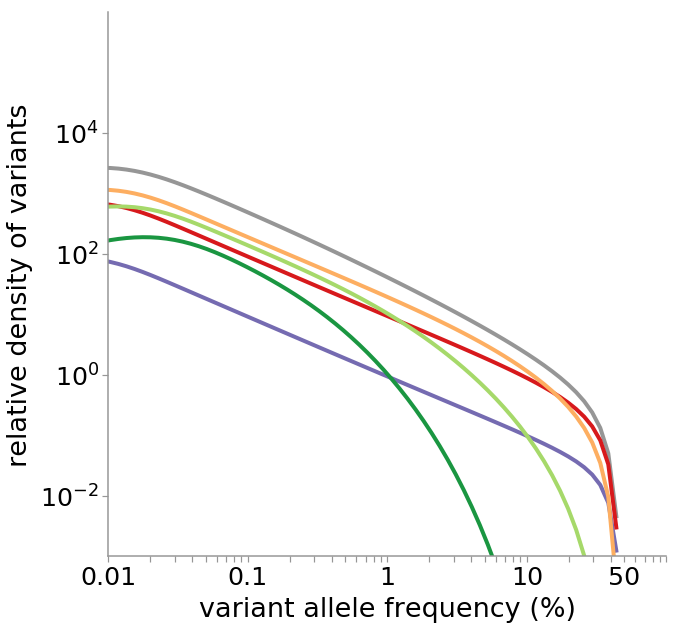

In [25]:
s_max_inferred = 1 # same result as 10

plt.close('all')
scale = 1.2
f, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(10, 10))
font = {'weight' : 'normal','size'   : 16}

x_passenger=np.linspace(np.log(10**-6), np.log(0.4999999), 100)

y_passenger_total = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_functional_non_syn_mu], N_tau, s_tolerance, s_max_inferred, list_of_control_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_total, c = grey3, lw = 4, label= 'total from 3.5 %')
print('y_passenger_total finished', y_passenger_total)

y_passenger_beyond_15p = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_functional_non_syn_mu], N_tau, 0.15, s_max_inferred, list_of_control_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_beyond_15p, c = color_beyond15p, lw = 4, label= 'beyond 15 %')
print('y_passenger_beyond_15p finished', y_passenger_beyond_15p)

y_passenger_15p = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_functional_non_syn_mu], N_tau, 0.12, 0.15, list_of_control_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_15p, c = color_15p, lw = 4, label= '12 - 15 %')
print('y_passenger_15p finished', y_passenger_15p)

y_passenger_12p = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_functional_non_syn_mu], N_tau, 0.09, 0.12, list_of_control_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_12p, c = color_12p, lw = 4, label= '9 - 12 %')
print('y_passenger_12p finished', y_passenger_12p)

y_passenger_9p = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_functional_non_syn_mu], N_tau, 0.06, 0.09, list_of_control_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_9p, c = color_9p, lw = 4, label= '6 - 9 %')
print('y_passenger_9p finished', y_passenger_9p)

y_passenger_6p = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_functional_non_syn_mu], N_tau, 0.035, 0.06, list_of_control_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_6p, c = color_6p, lw = 4, label= '3.5 - 6 %')
print('y_passenger_6p finished', y_passenger_6p)

# Set axis limits
ax1.set_ylim(np.log(10**-3), np.log(1000000))
ax1.set_xlim(np.log(10**-4),np.log(0.5))

# # Axis labels
axisfont=14*1.2
axislabelfont=15*1.2

ax1.set_xlabel('variant allele frequency (%)', fontsize = axislabelfont*1.5, labelpad = 6*1.2, fontweight = 'medium')
ax1.set_ylabel('relative density of variants', fontsize = axislabelfont*1.5, labelpad = 6*1.2, fontweight = 'medium')

x_major_ticks = [np.log(0.0001),np.log(0.0002),np.log(0.0003),np.log(0.0004),np.log(0.0005),np.log(0.0006),np.log(0.0007),np.log(0.0008), np.log(0.0009),\
                 np.log(0.001), np.log(0.002),np.log(0.003),np.log(0.004),np.log(0.005),np.log(0.006),np.log(0.007),np.log(0.008),np.log(0.009), \
                 np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                 np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]
x_major_tick_labels = ["0.01","","","","","","","","",\
                       "0.1","","","","","","","","",\
                       "1","","","","","","","","",\
                       "10","","","","50","","","","",""]
ax1.set_xticks(x_major_ticks)
ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont*1.5)
ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)

y_major_ticks = [np.log(10**-2), np.log(1), np.log(10**2), np.log(10**4)]
y_major_tick_labels = [ "$10^{-2}$","$10^{0}$","$10^{2}$","$10^{4}$",]

ax1.set_yticks(y_major_ticks)
ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont*1.5)
ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)

#Only show the required axis lines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(1.5)

for axis in ['bottom','left']:
    ax1.spines[axis].set_color(grey3)
        
# ax1.legend(frameon=0, fontsize= 18)


# plt.savefig('Reed_model_pfree_Bolton_ages_all468_genes.pdf', bbox_inches='tight')        


# Analytical approximations

Analytical approximations to the most dominant s.

In [206]:
freq=2/100
print('freq',freq)
n_tau = 2*N_tau*freq/(1-2*freq)
print('n_tau:',n_tau)
t = max(list_of_control_ages)
t = 40
print('t',t)

first_order_derivative_A_C_only= lambda s: (-2-p_inferred*(s/q_inferred)**p_inferred)+s*(t+(s*t+1)*n_tau*np.exp(-s*t))
    
first_order_derivative_A_C_D_only= lambda s: ((-2-p_inferred*(s/q_inferred)**p_inferred)+s*(t+(s*t+1)*n_tau*np.exp(-s*t)))*np.exp(s*t-n_tau*s*np.exp(-s*t))-\
s*np.exp(-n_tau*s)*(n_tau*(np.exp(s*t)-1)+t*np.exp(s*t)+n_tau*s*t*np.exp(s*t))

first_order_derivative_A_B_C_D_only= lambda s: ((-2-p_inferred*(s/q_inferred)**p_inferred)+s*(t+(s*t+1)*n_tau*np.exp(-s*t)))*np.exp(s*t-n_tau*s*np.exp(-s*t))-\
s*np.exp(-n_tau*s)*(n_tau*(np.exp(s*t)-1)+t*np.exp(s*t)+n_tau*s*t*np.exp(s*t))+np.exp(-n_tau*s)*(np.exp(s*t)+n_tau*s*(np.exp(s*t)-1))*(s-(-2-p_inferred*(s/q_inferred)**p_inferred))
    

freq 0.02
n_tau: 4166.666666666667
t 40


In [79]:
from scipy.optimize import fsolve

predominant_s_initial_guess = 0.3

predominant_s_solution_A_C_only = fsolve(first_order_derivative_A_C_only, predominant_s_initial_guess)

predominant_s_solution_A_C_D_only = fsolve(first_order_derivative_A_C_D_only, predominant_s_initial_guess)

predominant_s_solution_A_B_C_D_only = fsolve(first_order_derivative_A_B_C_D_only, predominant_s_initial_guess)

print('predominant_s_solution_A_C_only ', predominant_s_solution_A_C_only)
print('predominant_s_solution_A_C_D_only ', predominant_s_solution_A_C_D_only)
print('predominant_s_solution_A_B_C_D_only ', predominant_s_solution_A_B_C_D_only)

predominant_s_solution_A_C_only  [0.11205507]
predominant_s_solution_A_C_D_only  [0.11205507]
predominant_s_solution_A_B_C_D_only  [0.11205507]


C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in double_scalars


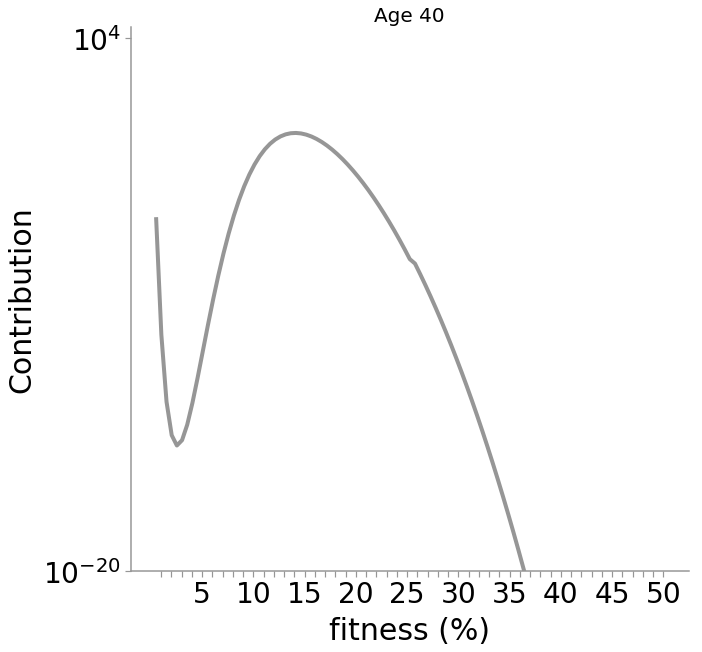

In [207]:
# Plot contribution to passenger spectrum from different s's
log_freq=np.log(freq)

plt.close('all')
scale = 1.2
fig, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(10, 10))
font = {'weight' : 'normal','size'   : 16}

# s_vector = np.linspace(0, s_max_inferred, 100)
s_vector = np.linspace(0, 0.5, 100)

Product = [np.log(expected_density_hitchhiker_mutants_s_single(t, log_freq, s1, p_inferred, q_inferred, Bolton_468panel_mu*ratio_nonneutral, N_tau)) for s1 in s_vector]
ax1.plot(s_vector, Product, c = grey3, lw = 4, label= 'total')



# Set axis limits
ax1.set_ylim(np.log(10**-20), np.log(3*10**4))
# ax1.set_xlim(-9, 0)

# # Axis labels
axisfont=14*2
axislabelfont=15*2

ax1.set_xlabel('fitness (%)', fontsize = axislabelfont, labelpad = 6*1.2, fontweight = 'medium')
ax1.set_ylabel('Contribution', fontsize = axislabelfont, labelpad = 6*1.2, fontweight = 'medium')

x_major_ticks = np.linspace(0.01,0.5,50)
x_major_tick_labels = ["", "","","","5","", "","","", "10","", "","","","15","", "","","", "20","", "","","", "25","", "","","", "30"\
                       ,"", "","","", "35","", "","","", "40","", "","","", "45","", "","","", "50"]
ax1.set_xticks(x_major_ticks)
ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont)
ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)

y_major_ticks =[np.log(10**-20), np.log(10**4)]
y_major_tick_labels = ["$10^{-20}$", "$10^{4}$"]
ax1.set_yticks(y_major_ticks)
ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont)
ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)
# ax1.axvline(predominant_s_solution_A_C_only[0], color='black', linewidth=4, linestyle='--', zorder = 0)



#Only show the required axis lines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(1.5)

for axis in ['bottom','left']:
    ax1.spines[axis].set_color(grey3)
        
ax1.set_title('Age 40', fontsize=20)
